In [539]:
import os
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class DictionarySizeIsNotSupported(Exception): pass
class StringsAreDifferentLength(Exception): pass
class OverlapSpecifiedIsNotSmallerThanWindowSize(Exception): pass


class SAX(object):
    """
    This class is for computing common things with the Symbolic
    Aggregate approXimation method.  In short, this translates
    a series of data to a string, which can then be compared with other
    such strings using a lookup table.
    """

    def __init__(self, wordSize = 8, alphabetSize = 7, epsilon = 1e-6):

        if alphabetSize < 3 or alphabetSize > 20:
            raise DictionarySizeIsNotSupported()
        self.aOffset = ord('a')
        self.wordSize = wordSize
        self.alphabetSize = alphabetSize
        self.eps = epsilon
        self.breakpoints = {'3' : [-0.43, 0.43],
                            '4' : [-0.67, 0, 0.67],
                            '5' : [-0.84, -0.25, 0.25, 0.84],
                            '6' : [-0.97, -0.43, 0, 0.43, 0.97],
                            '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
                            '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
                            '9' : [-1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
                            '10': [-1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
                            '11': [-1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
                            '12': [-1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
                            '13': [-1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
                            '14': [-1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
                            '15': [-1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
                            '16': [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
                            '17': [-1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
                            '18': [-1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
                            '19': [-1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
                            '20': [-1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]
                            }
        self.beta = self.breakpoints[str(self.alphabetSize)]
        self.build_letter_compare_dict()
        self.scalingFactor = 1


    def to_letter_rep(self, x):
        """
        Function takes a series of data, x, and transforms it to a string representation
        """
        (paaX, indices) = self.to_PAA(self.normalize(x))
        self.scalingFactor = np.sqrt((len(x) * 1.0) / (self.wordSize * 1.0))
        return (self.alphabetize(paaX), indices)

    def normalize(self, x):
        """
        Function will normalize an array (give it a mean of 0, and a
        standard deviation of 1) unless it's standard deviation is below
        epsilon, in which case it returns an array of zeros the length
        of the original array.
        """
        X = np.asanyarray(x)
        if np.nanstd(X) < self.eps:
            res = []
            for entry in X:
                if not np.isnan(entry):
                    res.append(0)
                else:
                    res.append(np.nan)
        return (X - np.nanmean(X)) / np.nanstd(X)

    def to_PAA(self, x):
        """
        Function performs Piecewise Aggregate Approximation on data set, reducing
        the dimension of the dataset x to w discrete levels. returns the reduced
        dimension data set, as well as the indices corresponding to the original
        data for each reduced dimension
        """
        n = len(x)
        stepFloat = n/float(self.wordSize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

    def alphabetize(self,paaX):
        """
        Converts the Piecewise Aggregate Approximation of x to a series of letters.
        """
        alphabetizedX = ''
        for i in range(0, len(paaX)):
            letterFound = False
            for j in range(0, len(self.beta)):
                if np.isnan(paaX[i]):
                    alphabetizedX += '-'
                    letterFound = True
                    break
                if paaX[i] < self.beta[j]:
                    alphabetizedX += chr(self.aOffset + j)
                    letterFound = True
                    break
            if not letterFound:
                alphabetizedX += chr(self.aOffset + len(self.beta))
        return alphabetizedX

    def compare_strings(self, sA, sB):
        """
        Compares two strings based on individual letter distance
        Requires that both strings are the same length
        """
        if len(sA) != len(sB):
            raise StringsAreDifferentLength()
        list_letters_a = [x for x in sA]
        list_letters_b = [x for x in sB]
        mindist = 0.0
        for i in range(0, len(list_letters_a)):
            if list_letters_a[i] is not '-' and list_letters_b[i] is not '-':
                mindist += self.compare_letters(list_letters_a[i], list_letters_b[i])**2
        mindist = self.scalingFactor* np.sqrt(mindist)
        return mindist

    def compare_letters(self, la, lb):
        """
        Compare two letters based on letter distance return distance between
        """
        return self.compareDict[la+lb]

    def build_letter_compare_dict(self):
        """
        Builds up the lookup table to determine numeric distance between two letters
        given an alphabet size.  Entries for both 'ab' and 'ba' will be created
        and will have identical values.
        """

        number_rep = range(0,self.alphabetSize)
        letters = [chr(x + self.aOffset) for x in number_rep]
        self.compareDict = {}
        for i in range(0, len(letters)):
            for j in range(0, len(letters)):
                if np.abs(number_rep[i]-number_rep[j]) <=1:
                    self.compareDict[letters[i]+letters[j]] = 0
                else:
                    high_num = np.max([number_rep[i], number_rep[j]])-1
                    low_num = np.min([number_rep[i], number_rep[j]])
                    self.compareDict[letters[i]+letters[j]] = self.beta[high_num] - self.beta[low_num]

    def sliding_window(self, x, numSubsequences = None, overlappingFraction = None):
        if not numSubsequences:
            numSubsequences = 20
        self.windowSize = int(len(x)/numSubsequences)
        if not overlappingFraction:
            overlappingFraction = 0.9
        overlap = self.windowSize*overlappingFraction
        moveSize = int(self.windowSize - overlap)
        if moveSize < 1:
            raise OverlapSpecifiedIsNotSmallerThanWindowSize()
        ptr = 0
        n = len(x)
        windowIndices = []
        stringRep = []
        while ptr < n-self.windowSize+1:
            thisSubRange = x[ptr:ptr+self.windowSize]
            (thisStringRep,indices) = self.to_letter_rep(thisSubRange)
            stringRep.append(thisStringRep)
            windowIndices.append((ptr, ptr+self.windowSize))
            ptr += moveSize
        return (stringRep,windowIndices)

    def batch_compare(self, xStrings, refString):
        return [self.compare_strings(x, refString) for x in xStrings]

    def set_scaling_factor(self, scalingFactor):
        self.scalingFactor = scalingFactor

    def set_window_size(self, windowSize):
        self.windowSize = windowSize

In [540]:
TrainingSetdf = pd.read_csv("BATADAL_dataset03.csv", parse_dates=True, index_col='DATETIME', dayfirst=True)
EvalSetdf=pd.read_csv("BATADAL_dataset04.csv", parse_dates=True, index_col='DATETIME', dayfirst=True)

In [541]:
sensor='L_T1'
signal=TrainingSetdf[sensor]
series=pd.Series(signal)
s = SAX(60, 3)

In [542]:
(trainString, x1Indices) = s.to_letter_rep(series)

trainString

'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb'

In [543]:
sensor2=" "+sensor
signalTest=EvalSetdf[sensor2]
seriesTest=pd.Series(signalTest)
s = SAX(60,3)


In [544]:
(TestString, xTestIndices) = s.to_letter_rep(seriesTest)
TestString


'bbbbbbabbbbbbbbbbbbbbbbbbbbbbbbbbcbbbbbbbbbbbbbbbbbbbbbbbbbb'

In [545]:
probabilityDict = {}
print(probabilityDict)

for i in range(len(TestString)-1):
    trigram=TestString[i-1:i+2]
    if trigram not in probabilityDict:
        count=0
        for j in range(len(trainString)-1):
            trainTempTrigram=trainString[j-1:j+2]
            if trainTempTrigram==trigram and trigram!='' :
                count+=1
        if trigram!='' :
            probabilityDict[trigram]=count/(len(trainString)-3)
print(probabilityDict)
        

{}
{'bbb': 1.0175438596491229, 'bba': 0.0, 'bab': 0.0, 'abb': 0.0, 'bbc': 0.0, 'bcb': 0.0, 'cbb': 0.0}


In [546]:
probabilityBigramDict = {"ab":0,"ba":0,"aa":0,"bb":0,"ca":0,"cb":0,"cc":0,"ac":0,"bc":0}
ab={"a":0,"b":0,"c":0}
ba={"a":0,"b":0,"c":0}
aa={"a":0,"b":0,"c":0}
bb={"a":0,"b":0,"c":0}
ca={"a":0,"b":0,"c":0}
cb={"a":0,"b":0,"c":0}
cc={"a":0,"b":0,"c":0}
ac={"a":0,"b":0,"c":0}
bc={"a":0,"b":0,"c":0}
for i in range(len(trainString)-1):
    trigram=trainString[i-1:i+2]
    
    if trigram[:2]=='ab':
        ab[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='ba':
        ba[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='aa':
        aa[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='bb':
        bb[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='ca':
        ca[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='cb':
        cb[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='cc':
        cc[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='ac':
        ac[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1
    elif trigram[:2]=='bc':
        bc[trigram[2]]+=1
        probabilityBigramDict[trigram[:2]]+=1

TransitionProbabilityDict={"ab":ab,"ba":ba,"aa":aa,"bb":bb,"ca":ca,"cb":cb,"cc":cc,"ac":ac,"bc":bc}
print(TransitionProbabilityDict)
for key,dic in TransitionProbabilityDict.items():
    total = sum(dic.values(), 0.0)
    if(total!=0):
        dic = {k: v / total for k, v in dic.items()}
        TransitionProbabilityDict[key]=dic
print(TransitionProbabilityDict)
print(probabilityBigramDict)
total = sum(probabilityBigramDict.values(), 0.0)
probabilityBigramDict = {k: v / total for k, v in probabilityBigramDict.items()}
print(probabilityBigramDict)

{'ab': {'a': 0, 'b': 0, 'c': 0}, 'ba': {'a': 0, 'b': 0, 'c': 0}, 'aa': {'a': 0, 'b': 0, 'c': 0}, 'bb': {'a': 0, 'b': 58, 'c': 0}, 'ca': {'a': 0, 'b': 0, 'c': 0}, 'cb': {'a': 0, 'b': 0, 'c': 0}, 'cc': {'a': 0, 'b': 0, 'c': 0}, 'ac': {'a': 0, 'b': 0, 'c': 0}, 'bc': {'a': 0, 'b': 0, 'c': 0}}
{'ab': {'a': 0, 'b': 0, 'c': 0}, 'ba': {'a': 0, 'b': 0, 'c': 0}, 'aa': {'a': 0, 'b': 0, 'c': 0}, 'bb': {'a': 0.0, 'b': 1.0, 'c': 0.0}, 'ca': {'a': 0, 'b': 0, 'c': 0}, 'cb': {'a': 0, 'b': 0, 'c': 0}, 'cc': {'a': 0, 'b': 0, 'c': 0}, 'ac': {'a': 0, 'b': 0, 'c': 0}, 'bc': {'a': 0, 'b': 0, 'c': 0}}
{'ab': 0, 'ba': 0, 'aa': 0, 'bb': 58, 'ca': 0, 'cb': 0, 'cc': 0, 'ac': 0, 'bc': 0}
{'ab': 0.0, 'ba': 0.0, 'aa': 0.0, 'bb': 1.0, 'ca': 0.0, 'cb': 0.0, 'cc': 0.0, 'ac': 0.0, 'bc': 0.0}


In [547]:
TestTrigramProbs={}
Anomalyindex=[]
counter=0
for i in range(1,len(TestString)-1):
    trigram=TestString[i-1:i+2]

    transition=TransitionProbabilityDict.get(trigram[:2],{})
    proba=probabilityBigramDict.get(trigram[:2])*transition.get(trigram[2])
    if(proba==0):
        Anomalyindex.append(i-1)
        counter+=1
    if trigram not in TestTrigramProbs:
        TestTrigramProbs[trigram]=proba
print(TestTrigramProbs)
print(Anomalyindex)
        

{'bbb': 1.0, 'bba': 0.0, 'bab': 0.0, 'abb': 0.0, 'bbc': 0.0, 'bcb': 0.0, 'cbb': 0.0}
[4, 5, 6, 31, 32, 33]


In [548]:
int(len(EvalSetdf[sensor2])/60)
batch=range(1,69)
dateindex=Anomalyindex[0]*int(len(EvalSetdf[sensor2])/60)
EvalSetdf.index[dateindex]
AllDatesDetected=[]
tp=0
fp=0
for el in Anomalyindex:
    
    for dateIndex in range(xTestIndices[el][0],xTestIndices[el][1]):
        date = EvalSetdf.index[dateIndex].strftime("%Y-%m-%d %H:%M:%S")
        if date not in AllDatesDetected:
            AllDatesDetected.append(date)
            #print(int(EvalSetdf.loc[date][43]))
            if EvalSetdf.loc[date][43]==1:
                tp+=1
            else:
                fp+=1
   

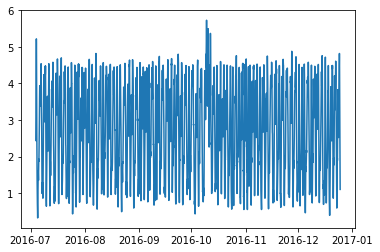

In [549]:
sensor2=" L_T1"
plt.plot(EvalSetdf[sensor2])


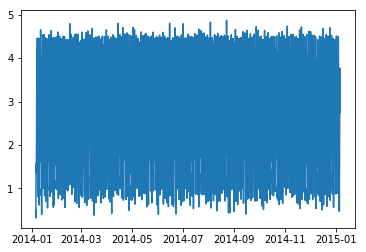

In [550]:
sensor="L_T1"
plt.plot(TrainingSetdf[sensor])